# 总测试 1

## 车牌提取

In [1]:
import cv2
from matplotlib import pyplot as plt

def plt_showRGB(img,*title):
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if len(title)==1:
        plt.title(title[0],fontsize='14',fontweight='bold',color='red')
    plt.imshow(img_rgb)
    plt.show()

# plt显示灰度图片
def plt_showGray(img,*title):
    if len(title)==1:
        plt.title(title[0],fontsize='14',fontweight='bold',color='red')
    plt.imshow(img,cmap='gray')
    plt.show()

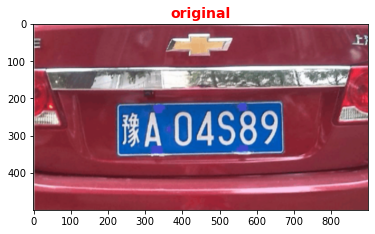

In [2]:
# 读取图像
original = cv2.imread("./image/test1.png")
plt_showRGB(original,'original')

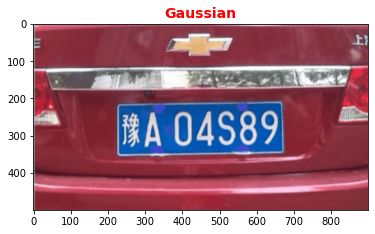

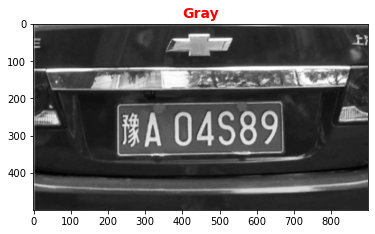

In [3]:
# 高斯滤波器降噪 + 灰度处理
image = cv2.GaussianBlur(original, (3, 3), 0)
plt_showRGB(image,'Gaussian')
# 灰度处理
imgGray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt_showGray(imgGray,'Gray')

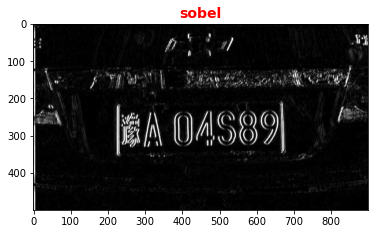

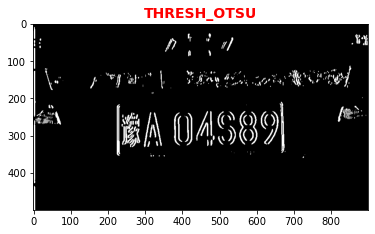

In [4]:
# sobel算子边缘检测
Sobel_x = cv2.Sobel(imgGray, cv2.CV_16S, 1, 0)
absX = cv2.convertScaleAbs(Sobel_x)  # 转回uint8
image = absX
plt_showGray(image,'sobel')

# 自适应阈值处理
ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_OTSU)
plt_showGray(image,'THRESH_OTSU')

将会用到的处理：
 - 闭运算:先膨胀，后腐蚀 （可用于去除黑点）
 - 开运算：先腐蚀，后膨胀 （可去除小白点）

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


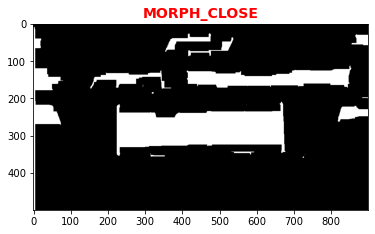

In [5]:
# 创建一个核（元素结构），尺寸为（17,5）
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 5))
print(kernel)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel,iterations = 3)
plt_showGray(image,'MORPH_CLOSE')

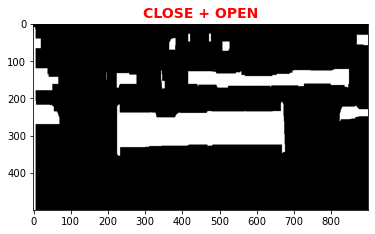

In [6]:
# 创建两个核，大小分别为 (20, 1)，(1, 19)
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 19))

# 用两个核分别做 一次闭运算 和 一次开运算
image = cv2.morphologyEx(image,cv2.MORPH_CLOSE,kernel1)
image = cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel2)


plt_showGray(image,'CLOSE + OPEN')

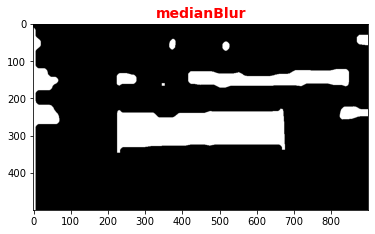

In [7]:
# 中值滤波去除噪点（使得更平滑）
image = cv2.medianBlur(image, 15)
plt_showGray(image,'medianBlur')

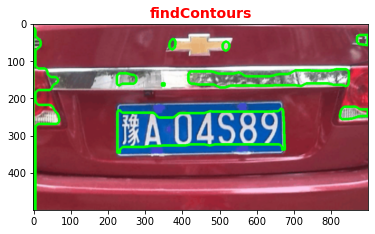

边缘个数： 9


In [8]:
# cv2.findContours 轮廓检测
# 获取轮廓
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 绘制轮廓
image1 = original.copy()
cv2.drawContours(image1, contours, -1, (0, 255, 0), 5)
plt_showRGB(image1,'findContours')
print('边缘个数：',len(contours))

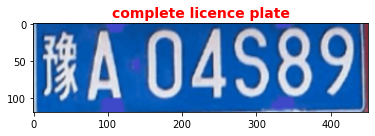

In [9]:
for item in contours:
    # cv2.boundingRect用一个最小的矩形，把找到的形状包起来
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    width = rect[2]
    height = rect[3]
    # 440mm×140mm
    if (width > (height * 2.5)) and (width < (height * 4)):
        image = original[y:y + height, x:x + width]
        # 图像保存
        plt_showRGB(image,'complete licence plate')
        cv2.imwrite('./outputImages/plate.png', image)

## 获取每个字符

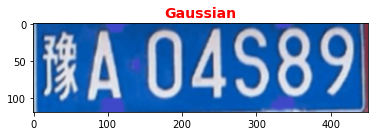

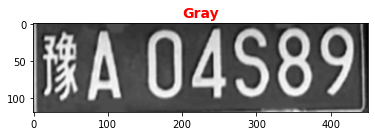

In [10]:
plate = image
# 用高斯滤波器降噪
image = cv2.GaussianBlur(plate, (3, 3), 0)
plt_showRGB(image,'Gaussian')
# 灰度处理
imgGray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt_showGray(imgGray,'Gray')

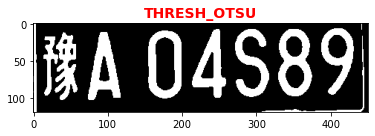

(119, 451)
white:  14656 blcak: 39013


In [11]:
# 自适应阈值处理
ret, image = cv2.threshold(imgGray, 127, 255, cv2.THRESH_OTSU)
plt_showGray(image,'THRESH_OTSU')

'''
处理绿牌照问题，让需要的车牌号码始终为前景，即白色
通过计算二值图像黑白点的个数，当白的个数大于黑点个数
用阈值分割实现黑白反转
'''
area_white = 0
area_black = 0
height, width = image.shape
print(image.shape)
for i in range(height):
    for j in range(width):
        if image[i, j] == 255:
            area_white += 1
        else:
            area_black += 1
print('white: ',area_white,'blcak:',area_black)
if area_white>area_black:
    ret, image = cv2.threshold(imgGray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    plt_showGray(image,'THRESH_BINARY_INV')

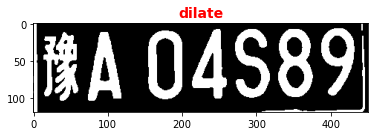

In [12]:
# 创建一个结构元素，用于形态学处理
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
# 膨胀操作，使单个文字成为一体，特指中文（因为中文文字整体不相连）
image = cv2.dilate(image, kernel)
plt_showGray(image,'dilate')

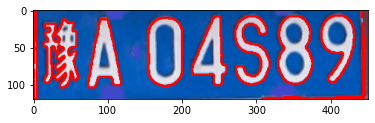

边缘个数为： 10


In [13]:
# cv2.findContours 轮廓检测
# 获取轮廓
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 绘制轮廓
image1 = plate.copy()
cv2.drawContours(image1, contours, -1, (0, 0, 255), 2)
plt_showRGB(image1)
print('边缘个数为：',len(contours))

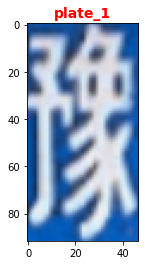

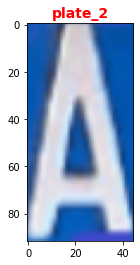

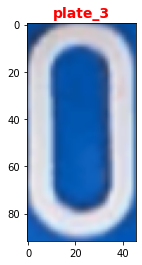

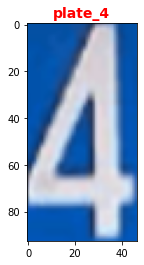

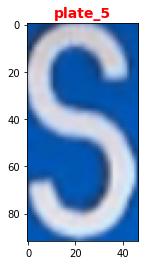

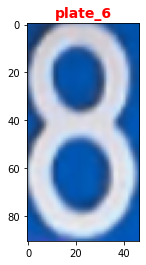

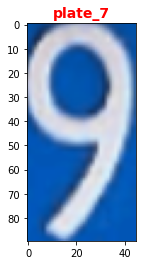

In [14]:
# 筛选出各个字符的位置的轮廓
words = []
for item in contours:
    # cv2.boundingRect找出一个能框住图形的最小的矩形
    word = []
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    width = rect[2]
    height = rect[3]
    if (height > (width * 1.8)) and (height < (width * 3.5)):
        word.append(x)
        word.append(y)
        word.append(width)
        word.append(height)
        words.append(word)
  
words = sorted(words,key=lambda s:s[0],reverse=False)
#print(words)
image_words = []
for index, word in enumerate(words):
    image = plate[word[1]:word[1] + word[3], word[0]:word[0] + word[2]]
    image_words.append(image)
    plt_showRGB(image,'plate_'+str(index+1))
     #cv2.imwrite('./outputImages/plate_'+str(index+1)+'.png', image)

## 识别文字

In [15]:
def imagesProcess(images,flag):
    images_process = []
    for image in images:
        # 用高斯滤波器降噪
        image = cv2.GaussianBlur(image, (3, 3), 0)
        # 灰度处理
        imgGray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # 自适应阈值处理
        ret, image = cv2.threshold(imgGray, 127, 255, cv2.THRESH_OTSU)
        
        # 处理绿牌照问题，让需要的车牌号码始终为前景，即白色
        # 通过计算二值图像黑白点的个数，当白的个数大于黑点个数
        # 用阈值分割实现黑白反转
        if flag == 1:
             ret, image = cv2.threshold(imgGray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        # area_white = 0
        # area_black = 0
        # height, width = image.shape
        # print(image.shape)
        # for i in range(height):
        #     for j in range(width):
        #         if image[i, j] == 255:
        #             area_white += 1
        #         else:
        #             area_black += 1
        # print('white: ',area_white,'blcak:',area_black)
        # if area_white>area_black:
        #     ret, image = cv2.threshold(imgGray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        # 创建一个结构元素，用于形态学处理
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        # 膨胀操作，使单个文字成为一体，特指中文（因为中文文字整体不相连）
        image = cv2.dilate(image, kernel)
        images_process.append(image)
    return images_process
   

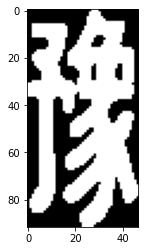

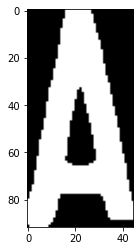

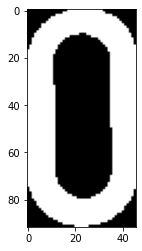

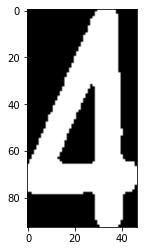

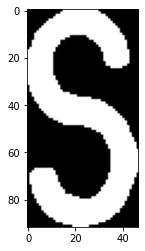

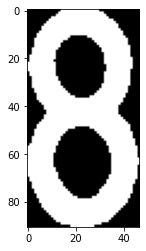

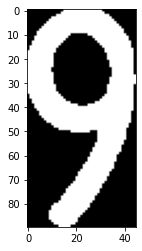

In [16]:
image_words = imagesProcess(image_words,0)
for item in image_words:
    plt_showGray(item)

47 92


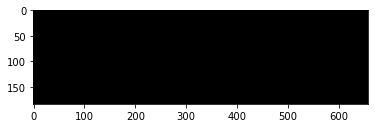

error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\core\src\arithm.cpp:234: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'cv::binary_op'


In [17]:
import numpy as np
# 把每个字符结合成一幅图
height,width = image_words[0].shape
print(width,height)

bg = np.zeros((height*2, width*len(image_words)*2),np.uint8)
plt_showGray(bg)
moveX = 20
for index,item in enumerate(image_words):
    height,width = item.shape
    roi = bg[45:height,moveX:width]
    newi = cv2.bitwise_or(item,roi)
    bg[45:height,moveX:width] = newi
    plt_showGray(bg)
    moveX += width
    